In [1]:
import torch
import torch2trt
import matplotlib.pyplot as plt
import cv2

ModuleNotFoundError: No module named 'torch2trt'

In [22]:
# Load the jetracer trained model 
model = torch.load('/models/run03/weights.pt')

In [23]:
model = model.cuda().eval().half()

In [24]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)['out']

In [25]:
model_w = ModelWrapper(model).half()

In [26]:
data = torch.ones((1,1,300,650)).cuda().half()

In [27]:
model_trt = torch2trt.torch2trt(model_w, [data], fp16_mode=True)

# Live demo

In [40]:
ino = 289
# Read  a sample image and mask from the data-set
img = cv2.imread(f'/workspace/models/train_data/Images/{ino:03d}_cam-image1_.jpg',cv2.CV_LOAD_IMAGE_GRAYSCALE).reshape(1,1,300,650)
mask = cv2.imread(f'/workspace/models/train_data/Masks/{ino:03d}_cam-image1_mask.png')
input = torch.from_numpy(img).type(torch.cuda.HalfTensor)/255

In [41]:
import time

torch.cuda.current_stream().synchronize()
t0 = time.time()
with torch.no_grad():
    output = model(input)
torch.cuda.current_stream().synchronize()
t1 = time.time()
print(1.0 / (t1 - t0))

2453.684647739837


In [42]:
output['out'].shape

torch.Size([1, 1, 300, 650])

(array([  1890., 155442.,   1146.,    902.,    821.,    815.,    850.,
           961.,   1316.,  30857.]),
 array([-0.1486, -0.0337,  0.0812,  0.196 ,  0.3108,  0.4258,  0.5405,
         0.6553,  0.7705,  0.8853,  1.    ], dtype=float16),
 <BarContainer object of 10 artists>)

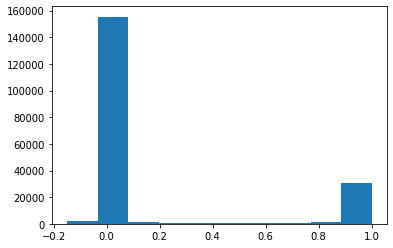

In [43]:
# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
plt.hist(output['out'].data.cpu().numpy().flatten())

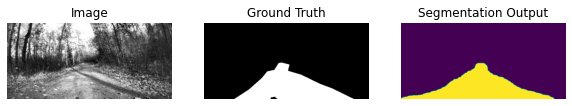

In [44]:
# Plot the input image, ground truth and the predicted output
plt.figure(figsize=(10,10));
plt.subplot(131);
plt.imshow(img[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(mask);
plt.title('Ground Truth')
plt.axis('off');
plt.subplot(133);
plt.imshow(output['out'].cpu().detach().numpy()[0][0]>0.4);
plt.title('Segmentation Output')
plt.axis('off');

In [45]:
import time

torch.cuda.current_stream().synchronize()
t0 = time.time()
output_trt = model_trt(input)
torch.cuda.current_stream().synchronize()
t1 = time.time()
print(1.0 / (t1 - t0))

6531.047476682083


In [46]:
output_trt[0].shape

torch.Size([1, 300, 650])

(array([  1920., 155428.,   1144.,    894.,    838.,    793.,    855.,
           944.,   1271.,  30913.]),
 array([-0.1486, -0.0337,  0.0812,  0.196 ,  0.3108,  0.4258,  0.5405,
         0.6553,  0.7705,  0.8853,  1.    ], dtype=float16),
 <BarContainer object of 10 artists>)

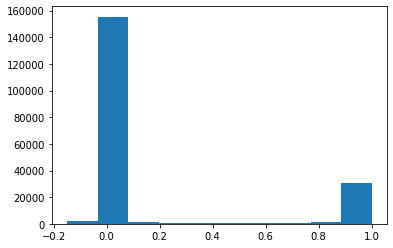

In [47]:
# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
plt.hist(output_trt[0].data.cpu().numpy().flatten())

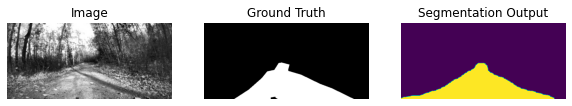

In [48]:
# Plot the input image, ground truth and the predicted output
trt = output_trt[0].detach().cpu().float().numpy()[0]>0.4

plt.figure(figsize=(10,10));
plt.subplot(131);
plt.imshow(img[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(mask);
plt.title('Ground Truth')
plt.axis('off');
plt.subplot(133);
plt.imshow(trt);
plt.title('Segmentation Output')
plt.axis('off');

In [52]:
torch.save(model_trt.state_dict(), '/workspace/models/run03/trt_model.pt')

In [53]:
from torch2trt import TRTModule

model_trt1 = TRTModule()

model_trt1.load_state_dict(torch.load('/workspace/models/run03/trt_model.pt'))

<All keys matched successfully>

In [54]:
import time

torch.cuda.current_stream().synchronize()
t0 = time.time()
output_trt1 = model_trt1(input)
torch.cuda.current_stream().synchronize()
t1 = time.time()
print(100.0 / (t1 - t0))

3338.3242731274026
